# Demand estimation section

In [1]:
import pyblp
import warnings
import numpy as np                
import pandas as pd               
import pyfixest as pf
import seaborn as sns               
from scipy import stats
from tqdm.auto import tqdm
from functools import partial           
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

In [2]:
df = pd.read_excel('data_blp.xlsx')
df.head()

/Users/ivanzamatin/anaconda3/envs/stable_ds/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,prices,shares,market_ids,firm_ids,product_ids,quality,satellite,wired,demand_instruments0
0,2.636681,0.469490,0,1,1,0.921656,1,0,0.072425
1,2.812415,0.237731,0,2,2,1.834763,1,0,0.548527
2,2.417776,0.038745,0,3,3,0.762334,0,1,0.868230
3,2.321038,0.163560,0,4,4,1.399432,0,1,0.135893
4,2.534516,0.114659,1,1,1,0.082587,1,0,0.235976


# Data Comprehension

In [3]:
# Filter data for market 0
market_0 = df[df['market_ids'] == 0]

# Sum shares for all goods in market 0
total_shares_market_0 = market_0['shares'].sum()

# Share of buyers that does not buy any of 4 goods
outside_share = 1 - total_shares_market_0

print(f"Share of buyers that does not buy any of 4 goods in market 0 : {outside_share}")

Share of buyers that does not buy any of 4 goods in market 0 : 0.09047369917765513


In [4]:
# Filter for satellite services (satellite == 1)
satellite_goods = market_0[market_0['satellite'] == 1]

# Sum the shares of all satellite services goods
total_satellite_share = satellite_goods['shares'].sum()

# Get the share of good 1 (product_ids == 1)
good_1_share = satellite_goods[satellite_goods['product_ids'] == 1]['shares'].iloc[0]

# Compute market share of good 1 within satellite services
good_1_market_share = good_1_share / total_satellite_share

print(f"Market share of good 1 within satellite services in market 0: {good_1_market_share}")

Market share of good 1 within satellite services in market 0: 0.663852271845465


In [5]:
# Filter for satellite services (satellite == 1)
satellite_goods = market_0[market_0['satellite'] == 1]

# Filter for wired services (wired == 1)
wired_goods = market_0[market_0['wired'] == 1]

# Compute average price for satellite services
avg_satellite_price = satellite_goods['prices'].mean()

# Compute average price for wired services
avg_wired_price = wired_goods['prices'].mean()

print(f"Average price of satellite services in market 0: {avg_satellite_price}")
print(f"Average price of wired services in market 0: {avg_wired_price}")

Average price of satellite services in market 0: 2.7245480816183614
Average price of wired services in market 0: 2.369407011191835


# Plain Logit and OLS

In [6]:
#Plain logit specification
logit_formulation = pyblp.Formulation('0 + prices + quality + satellite + wired')
logit_formulation

#Creating problem and solving it
problem = pyblp.Problem(logit_formulation, df)
problem

logit_results = problem.solve()
logit_results

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD 
----  ----  ---  ----  ----
1000  4000   4    4     4  

Formulations:
     Column Indices:          0        1         2        3  
--------------------------  ------  -------  ---------  -----
X1: Linear Characteristics  prices  quality  satellite  wired
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 1    +5.153124E-24     0      +2.244862E+01      +1.663582E+03  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  ------- 

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 2    +1.199409E-24     0      +2.322815E+01      +1.663582E+03  

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    prices           quality         satellite          wired     
---------------  ---------------  ---------------  ---------------
 -1.988268E+00    +9.431118E-01    +4.065845E+00    +3.030266E+00 
(+5.589192E-02)  (+2.543810E-02)  (+1.520574E-01)  (+1.454054E-01)

### Beta Estimates (Robust SEs in Parentheses)


| Variable   | Coefficient     | (Robust SE)     |
|------------|-----------------|-----------------|
| prices     | -1.988268E+00   | (5.589192E-02)  |
| quality    | +9.431118E-01   | (2.543810E-02)  |
| satellite  | +4.065845E+00   | (1.520574E-01)  |
| wired      | +3.030266E+00   | (1.454054E-01)  |

As we can see, $\beta_2 = 4.065845$ and $\beta_3 = 3.030266 \rightarrow \beta_2>\beta_3\rightarrow$ on avarage, *satellite* service provides *more utility* at the baseline (zero) 
level of quality, than wired

In [7]:
# Drop instrument for OLS
data_ols = df.drop(columns=['demand_instruments0'])
data_ols['demand_instruments0'] = data_ols['prices']

# Same formulation
product_formulation = pyblp.Formulation('0 + quality + satellite + wired + prices')

# Create and solve problem (now OLS)
problem_ols = pyblp.Problem(product_formulation, data_ols)
results_ols = problem_ols.solve()

print(results_ols)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD 
----  ----  ---  ----  ----
1000  4000   4    4     4  

Formulations:
     Column Indices:           0         1        2      3   
--------------------------  -------  ---------  -----  ------
X1: Linear Characteristics  quality  satellite  wired  prices
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 1    +3.666593E-24     0      +8.167860E+02      +1.217868E+03  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  ------- 

Ofcourse, when we estimate logit model without instrumets, the estimates will be **biased** because price variable is endogenous. 

This bias occurs because price is **positively correlated** with the unobserved quality ξ (higher quality goods have higher prices), leading to **endogeneity**. That is why, normaly we asume that OLS estimater will unsserestimate coeficients and they will be closer to zero. So, as we can see from above table of estimations $|\beta_{IV}| > |\beta_{OLS}| \rightarrow |-1.9882| > |-1.09488|$ and $\beta_{OLS}$ is *closer to zero*, we can conclude that result is valid. 

As a qualitative explanation, consider TV market, firms might set higher prices for products with unobserved advantages (e.g., exclusive content or better technical support), and OLS fails to disentangle this from the direct price effect.

Computing elasticities with respect to prices ...
Finished after 00:00:00.

              p1        p2        p3        p4
Good 1 -2.781160  1.329352  0.186255  0.754804
Good 2  2.461271 -4.262484  0.186255  0.754804
Good 3  2.461271  1.329352 -4.620933  0.754804
Good 4  2.461271  1.329352  0.186255 -3.860042


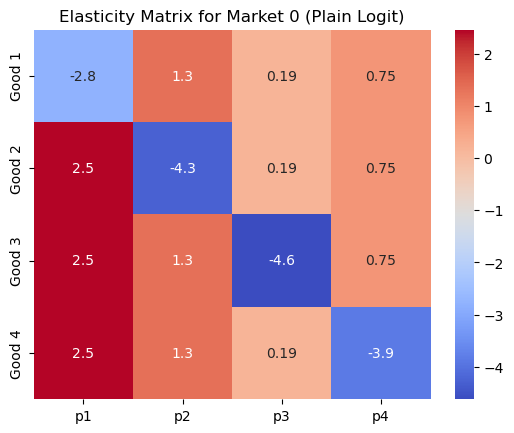

In [8]:
# Compute elasticities for market 0
elasticities = logit_results.compute_elasticities(market_id=0)

# Visualize as a matrix
elasticity_matrix = pd.DataFrame(elasticities, index=['Good 1', 'Good 2', 'Good 3', 'Good 4'], columns=['p1', 'p2', 'p3', 'p4'])
print(elasticity_matrix)

# For heatmap visualization
sns.heatmap(elasticity_matrix, annot=True, cmap='coolwarm')
plt.title('Elasticity Matrix for Market 0 (Plain Logit)')
plt.show()

The elasticity of the share of good 2 with respect to price of good 4 is equal to **0.75**. This value represents the percentage ***change in the market share of good 2 when the price of good 4 increases by 1%***. So, goods 2 and 4 are *slightly substituted*.

In [9]:
# Get delta for market 0 (mean utilities)
delta_market0 = logit_results.delta[ df['market_ids'] == 0 ]

# Utilities for inside goods
u1 = delta_market0[0] + (-1)
u2 = delta_market0[1] + 0
u3 = delta_market0[2] + 1.5
u4 = delta_market0[3] + (-2)
u0 = 0.8

# Choose the good with max utility
utilities = [u0, u1, u2, u3, u4]
chosen_good = utilities.index(max(utilities))  # 0 for outside, 1-4 for goods
print(f"Alice chooses good {chosen_good}")

Alice chooses good 2


In [10]:
satellite_market0 = market_0[market_0['satellite'] == 1]
xY = satellite_market0['quality'].mean()  # ≈ 1.3782096073064366
pY = satellite_market0['prices'].mean()  # ≈ 2.7245480816183615

# Compute deltaY using estimates from (a)
beta1, beta2, beta3, alpha = logit_results.beta.flatten()[[0,1,2,3]]  # Order: quality, sat, wired, prices (alpha = -coef)
deltaY = beta1 * xY + beta2 * 1 + beta3 * 0 + alpha * pY  # alpha is negative coef

# Existing sum_exp = 1 / s0 - 1
s0 = outside_share  # from 3.1(a)
sum_exp_existing = 1 / s0 - 1

# New share Y
shareY = np.exp(deltaY) / (1 + sum_exp_existing + np.exp(deltaY))
print(shareY)

0.9829811728816458


# Nested Logit

Each nest (satellite, wired) always has exactly 2 goods in every market. There is no variation in this number, so it provides no identifying information for estimating ρ (λ).

In [11]:
# Create nest_id
df['nesting_id'] = np.where(df['satellite'] == 1, 'sat', 'wired')

# Compute sum quality in nest, subtract own
df['demand_instruments1'] = df.groupby(['market_ids', 'nesting_id'])['quality'].transform('sum') - df['quality']

df.head()

,prices,shares,market_ids,firm_ids,product_ids,quality,satellite,wired,demand_instruments0,nesting_id,demand_instruments1
0,2.636681,0.469490,0,1,1,0.921656,1,0,0.072425,sat,1.834763
1,2.812415,0.237731,0,2,2,1.834763,1,0,0.548527,sat,0.921656
2,2.417776,0.038745,0,3,3,0.762334,0,1,0.868230,wired,1.399432
3,2.321038,0.163560,0,4,4,1.399432,0,1,0.135893,wired,0.762334
4,2.534516,0.114659,1,1,1,0.082587,1,0,0.235976,sat,0.246727


In [12]:
# Define a function that constructs the additional instrument and solves the nested logit
def solve_nl(df):
    nl_formulation = pyblp.Formulation('0 + quality + satellite + wired + prices')
    problem = pyblp.Problem(nl_formulation, df)
    return problem.solve(rho=0.7)

In [13]:
# Results of nested logtit
df2 = df.copy()
df2['nesting_ids'] = df2['satellite']
nl_results = solve_nl(df2)
nl_results

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    H 
----  ----  ---  ----  ----  ---
1000  4000   4    4     5     2 

Formulations:
     Column Indices:           0         1        2      3   
--------------------------  -------  ---------  -----  ------
X1: Linear Characteristics  quality  satellite  wired  prices
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...



GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1     00:00:00         0             1            0            0          0     +9.417105E+01                 +3.076164E+02  +7.000000E-01
 1     00:00:00         0             2            0            0          0     +1.933783E+00  +9.223727E+01  +4.408133E+01  +0.000000E+00
 1     00:00:00         1             3            0            0          0     +1.467219E-23  +1.933783E+00  +8.276411E-12  +8.773708E-02

Optimization completed after 00:00:01.
Computing the Hessian and updating the weighting matrix ...
Computed results after 00:00:01.

Problem Results Summary:
G

Problem Results Summary:
GMM     Objective      Projected       Reduced     Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm     Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +1.684221E-23  +9.324762E-11  +5.555857E+02     0      +3.911716E+01      +3.135987E+03  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:03       Yes          2             6     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 +8.773708E-02 
(+5.999840E-02)

Beta Estimates (Robust SEs in Parentheses):
    quality         satellite          wired           prices     
---------------  ---------------  ---------------  ---------------
 +9.019693E-01    +3.882292E+00    +2.865902E+00    -1.881339E+00 
(+3.726072E-0

From above table it become obvious, that ρ is close to zero and that is why data does not show strong nesting by service type and correlation is tiny.

Computing elasticities with respect to prices ...
Finished after 00:00:00.

              p1        p2        p3        p4
Good 1 -2.791956  1.428915  0.176238  0.714210
Good 2  2.645611 -4.371062  0.176238  0.714210
Good 3  2.328903  1.257859 -4.726102  1.053744
Good 4  2.328903  1.257859  0.260021 -3.732878


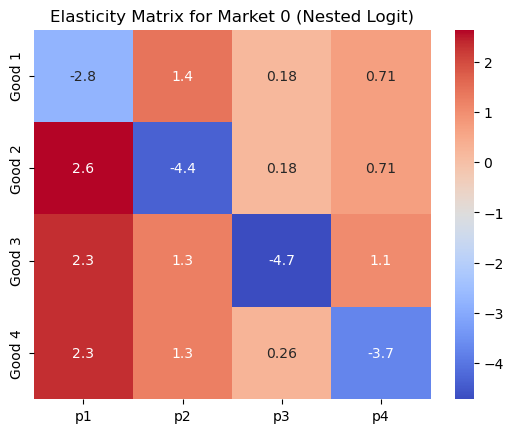

In [14]:
# Compute elasticities for market 0
elasticities_nested = nl_results.compute_elasticities(market_id=0)

# Visualize as a matrix
elasticity_matrix_nested = pd.DataFrame(elasticities_nested, index=['Good 1', 'Good 2', 'Good 3', 'Good 4'], columns=['p1', 'p2', 'p3', 'p4'])
print(elasticity_matrix_nested)

# For heatmap visualization
sns.heatmap(elasticity_matrix_nested, annot=True, cmap='coolwarm')
plt.title('Elasticity Matrix for Market 0 (Nested Logit)')
plt.show()

A numerical value of the elasticity of the share of good 2 with respect to price of good 4 in market 0 is equal to **0.71** < **0.75** which is less than in case of plain logit. The reason why value of elasticity in nested logit is less than in case of plain logit, because good 2 (satellite) and good 4 (wired) are in different nests, leading to **weaker cross-elasticity** (less substitution across nests).

# Mixed Logit

In nested logit, the correlation between goods within a single “branch” is specified through the parameter ρ (λ), which reflects the common component of the utility shock between goods within the same group. This correlation is driven by the structure of the ε errors.

In mixed logit, on the other hand, the correlation between goods choices arises from the heterogeneity of consumer preferences, which is represented by the distribution of random coefficients $(β_i^{(2)}, β_i^{(3)})$. The ε errors remain independent.

Thus, even if the distribution $(β_i^{(2)}, β_i^{(3)})$ is normal and independent, the model structure is fundamentally different — mixed logit allows for arbitrary (including non-logistic) correlations between choice probabilities, while nested logit allows only for correlations determined by the common component λ -> The difference lies not only in the distribution of coefficients, but also in the mechanism of correlation between alternatives.

When we integrate over the distribution of β, the expected value depends not only on the average effect, but also on the covariance between the random component β and the price p_{jt}, which may be endogenous -> This introduces additional endogeneity, as variations in individual coefficients may be correlated with invisible shocks ξ (for example, if firms set prices knowing that there are more "loyal" consumers in their region).

To eliminate this additional endogeneity, we need another tool that helps us identify the distribution parameters of the random coefficients (in addition to the tools for price and structural characteristics).

In [15]:
blp_instr = pyblp.build_blp_instruments(pyblp.Formulation('0 + quality'), df)
df2['demand_instruments2'] = blp_instr[:, 1]  
df2.head()

,prices,shares,market_ids,firm_ids,product_ids,quality,satellite,wired,demand_instruments0,nesting_id,demand_instruments1,nesting_ids,demand_instruments2
0,2.636681,0.469490,0,1,1,0.921656,1,0,0.072425,sat,1.834763,1,3.996530
1,2.812415,0.237731,0,2,2,1.834763,1,0,0.548527,sat,0.921656,1,3.083422
2,2.417776,0.038745,0,3,3,0.762334,0,1,0.868230,wired,1.399432,0,4.155852
3,2.321038,0.163560,0,4,4,1.399432,0,1,0.135893,wired,0.762334,0,3.518753
4,2.534516,0.114659,1,1,1,0.082587,1,0,0.235976,sat,0.246727,1,0.924706


In [16]:
df3 = df2.copy()

In [17]:
del df3['nesting_ids']
del df3['nesting_id']
df3.head()

,prices,shares,market_ids,firm_ids,product_ids,quality,satellite,wired,demand_instruments0,demand_instruments1,demand_instruments2
0,2.636681,0.469490,0,1,1,0.921656,1,0,0.072425,1.834763,3.996530
1,2.812415,0.237731,0,2,2,1.834763,1,0,0.548527,0.921656,3.083422
2,2.417776,0.038745,0,3,3,0.762334,0,1,0.868230,1.399432,4.155852
3,2.321038,0.163560,0,4,4,1.399432,0,1,0.135893,0.762334,3.518753
4,2.534516,0.114659,1,1,1,0.082587,1,0,0.235976,0.246727,0.924706


In [18]:
# Integration: 100 Monte Carlo draws per market, seed 0
mc_integration = pyblp.Integration('monte_carlo', size=100, specification_options={'seed': 0})

# Optimization with convergence tolerance
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-6})

# Formulations: X1 fixed, X2 random (include sat/wired in both for means)
linear_formulation = pyblp.Formulation('0 + quality + prices + satellite + wired')
nonlinear_formulation = pyblp.Formulation('0 + satellite + wired')

# Problem
problem_mixed = pyblp.Problem((linear_formulation, nonlinear_formulation), df3, integration=mc_integration)

# Initial sigma (diagonal)
initial_sigma = np.diag([0.5, 0.5])

results_mixed = problem_mixed.solve(sigma=initial_sigma, optimization=bfgs)

print(results_mixed)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F     I      K1    K2    MD 
----  ----  ---  ------  ----  ----  ----
1000  4000   4   100000   4     2     6  

Formulations:
       Column Indices:             0        1         2        3  
-----------------------------  ---------  ------  ---------  -----
 X1: Linear Characteristics     quality   prices  satellite  wired
X2: Nonlinear Characteristics  satellite  wired                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +5.000000E-01               
  wired    +0.000000E+00  +5.000000E-01

Nonlinear Coefficient Lower Bounds:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite      -INF                    
  wired    +0.000000E+00      -INF     

Nonlinear Coefficient Upper Bounds:
 Sigma:      satellite        wired    
---------  -

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm                  Theta            
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  ----------------------------
 1     00:00:01         0             1          5813         18148        0     +2.309468E+00                 +3.943583E+00  +5.000000E-01, +5.000000E-01
 1     00:00:01         0             2          7251         22296        0     +2.967516E+00                 +8.276418E+00  +1.276864E+00, +1.145432E+00
 1     00:00:01         0             3          6671         20636        0     +5.553675E-01  +1.754101E+00  +6.310331E-01  +8.791342E-01, +8.149913E-01
 1     00:00:01         1             4          6755         20883   

$\hat{\beta}^{(2)}_i = 4.19684, \hat{\beta}^{(3)}_i = 3.2365, se_{\hat{\beta}^{(2)}_i} = 0.17316, se_{\hat{\beta}^{(3)}_i} = 0.186636 \rightarrow se_{\hat{\beta}^{(2)}_i} < se_{\hat{\beta}^{(3)}_i}$. Wired services have a higher variance of utility in the population. This means that consumer preferences for wired services are more polarized or diverse than for satellite services. In other words, there is a wider spread of opinions about wired services. This can happen, fro example, because the quality of wired service is highly dependent on local infrastructure. In areas with modern, well-maintained cable lines (e.g., fiber-optic), service can be extremely reliable and fast, leading to very high satisfaction. In other areas with old, copper-based infrastructure, service can be prone to outages and slow speeds, leading to intense frustration. This creates a wide gap in consumer experiences and thus utility. On other hand, satellite service has lower varianse because of more uniform national offering. Satellite service is largely the same regardless of location (urban vs. rural). While weather can be a factor, the core service quality, channel offerings, and technology are consistent across the country. This leads to a more standardized consumer experience, resulting in less extreme variation in preferences.

In [19]:
beta = results_mixed.beta
mean_beta2 = beta[2]
alpha = -beta[1]
average_wtp = mean_beta2 / alpha
print(f"Average WTP: {average_wtp}")

Average WTP: [2.01252188]


In [20]:
# Sigma is the Cholesky factor; compute the covariance matrix 
sigma = results_mixed.sigma
covariance_matrix = sigma @ sigma.T
sd_beta2 = np.sqrt(covariance_matrix[0, 0])

# Z-score for 95% confidence interval (two-tailed)
z_score_95 = 1.96

# Lower bound: (mean - 1.96 * SD) / alpha
wtp_lower = (mean_beta2 - z_score_95 * sd_beta2) / alpha

# Upper bound: (mean + 1.96 * SD) / alpha
wtp_upper = (mean_beta2 + z_score_95 * sd_beta2) / alpha

print(f"95% Lower Bound of WTP: {wtp_lower}")
print(f"95% Upper Bound of WTP: {wtp_upper}")

95% Lower Bound of WTP: [0.82877423]
95% Upper Bound of WTP: [3.19626953]


# Supply estimaion section

In [21]:
df = pd.read_csv('data_op.csv')

In [22]:
df.head()

,firm_id,output,capital,labor,investment,year
0,2.0,34.971709,11.438735,0.865369,2.021582,1.0
1,2.0,78.796583,31.502661,1.854994,8.031911,2.0
2,2.0,202.864172,30.844545,1.648945,13.754778,3.0
3,2.0,198.344489,30.887850,1.767392,12.509195,4.0
4,2.0,219.231968,32.854417,1.772699,14.674547,5.0


## Data manipulations

In [23]:
df['ln_out'] = np.log(df['output'])
df['ln_inv'] = np.log(df['investment'])
df['ln_lab'] = np.log(df['labor'])
df['ln_cap'] = np.log(df['capital'])

df['ln_out_l1'] = df.sort_values('year').groupby('firm_id')['ln_out'].shift(1)
df['ln_inv_l1'] = df.sort_values('year').groupby('firm_id')['ln_inv'].shift(1)
df['ln_lab_l1'] = df.sort_values('year').groupby('firm_id')['ln_lab'].shift(1)
df['ln_cap_l1'] = df.sort_values('year').groupby('firm_id')['ln_cap'].shift(1)

df = df.sort_values(['firm_id', 'year']).reset_index(drop=True)
df['next_year'] = df.groupby('firm_id')['year'].shift(-1)
df['exit'] = (df['next_year'].isna()).astype(int)
    
df = df.drop(columns=['next_year'])

In [24]:
df.head()

,firm_id,output,capital,labor,investment,year,ln_out,ln_inv,ln_lab,ln_cap,ln_out_l1,ln_inv_l1,ln_lab_l1,ln_cap_l1,exit
0,2.0,34.971709,11.438735,0.865369,2.021582,1.0,3.554539,0.703880,-0.144600,2.437005,NaN,NaN,NaN,NaN,0
1,2.0,78.796583,31.502661,1.854994,8.031911,2.0,4.366870,2.083423,0.617882,3.450072,3.554539,0.703880,-0.144600,2.437005,0
2,2.0,202.864172,30.844545,1.648945,13.754778,3.0,5.312537,2.621386,0.500136,3.428960,4.366870,2.083423,0.617882,3.450072,0
3,2.0,198.344489,30.887850,1.767392,12.509195,4.0,5.290005,2.526464,0.569505,3.430363,5.312537,2.621386,0.500136,3.428960,0
4,2.0,219.231968,32.854417,1.772699,14.674547,5.0,5.390130,2.686115,0.572503,3.492086,5.290005,2.526464,0.569505,3.430363,0


In [25]:
def create_balanced_panel(df, verbose=True):
    df = df.sort_values(['firm_id', 'year']).reset_index(drop=True)
    
    all_years = sorted(df['year'].unique())
    n_years = len(all_years)
    
    if verbose:
        print(f"\nGeneral year in data: {all_years}")
        print(f"Quantity of years: {n_years}")
    
    balanced_firms = []
    
    for firm_id, firm_data in df.groupby('firm_id'):
        firm_years = sorted(firm_data['year'].unique())
        
        if len(firm_years) == n_years and firm_years == all_years:
            balanced_firms.append(firm_id)
    
    balanced_df = df[df['firm_id'].isin(balanced_firms)].copy()
    
    if verbose:
        print(f"\nBase quantity of firms: {df['firm_id'].nunique()}")
        print(f"Quantity of firms in balanced set: {len(balanced_firms)}")
        print(f"Base quantity of observations: {len(df)}")
        print(f"Quantity of observations in balanced set: {len(balanced_df)}")
    
    return balanced_df

In [26]:
balanced_df = create_balanced_panel(df)


General year in data: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Quantity of years: 9

Base quantity of firms: 672
Quantity of firms in balanced set: 34
Base quantity of observations: 3956
Quantity of observations in balanced set: 306


## Data description

In [27]:
df[['output', 'labor', 'capital','investment']].describe()

,output,labor,capital,investment
count,3956.000000,3956.000000,3956.000000,3956.000000
mean,1440.374959,11.714910,664.235905,105.568294
std,6994.868973,45.276011,2994.697222,520.341535
min,0.391962,0.031332,0.264562,0.042346
25%,58.211385,0.690413,14.429227,2.405078
50%,182.657338,2.245048,46.635732,8.657380
75%,725.245633,8.235956,242.051306,39.149887
max,149621.413539,995.335901,40790.543936,10765.737844


In [28]:
balanced_df[['output', 'labor', 'capital','investment']].describe()

,output,labor,capital,investment
count,306.000000,306.000000,306.000000,306.000000
mean,4463.572118,33.198814,1365.844979,245.651772
std,19877.627035,134.167048,5300.533490,1180.784978
min,6.089172,0.132524,2.325204,0.084282
25%,84.859200,0.628795,23.426830,2.708147
50%,257.066551,2.891436,57.736204,11.680149
75%,1810.420693,21.558924,556.676085,54.060972
max,149621.413539,995.335901,40790.543936,10765.737844


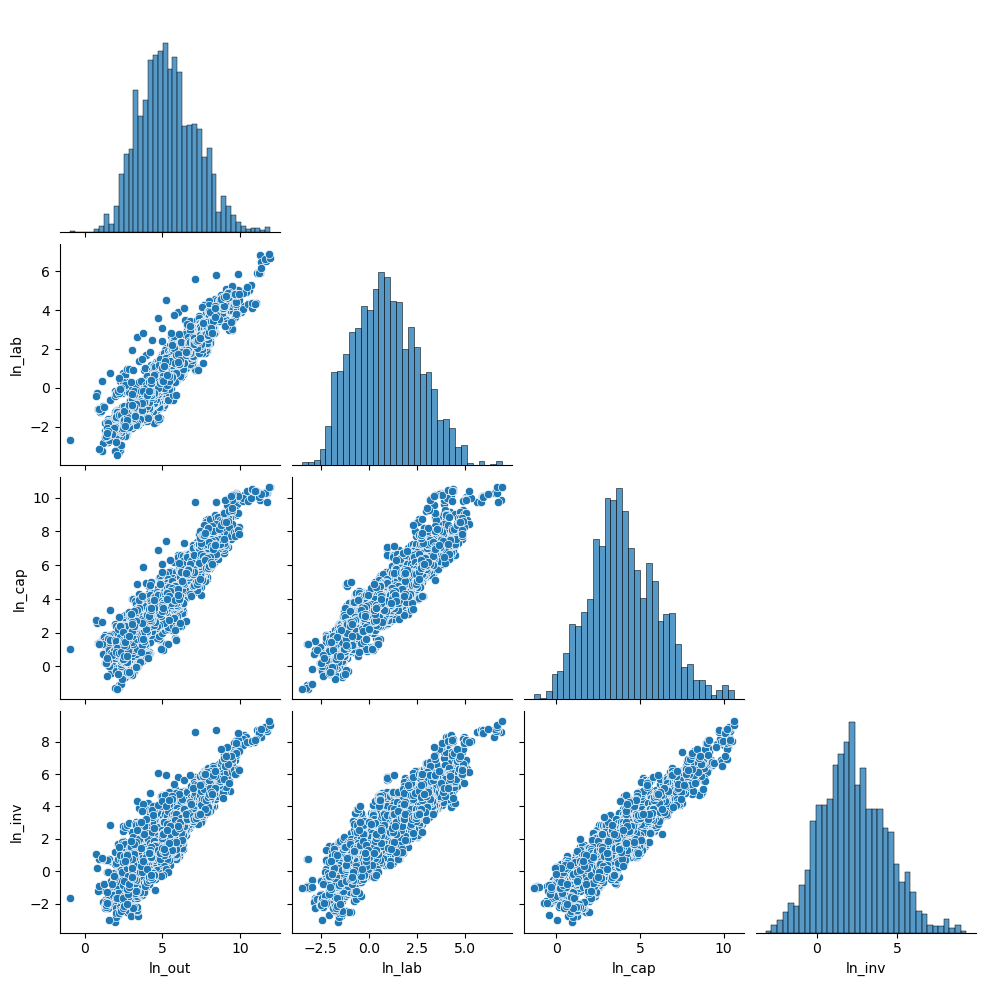

In [29]:
sns.pairplot(data=df, vars=['ln_out', 'ln_lab', 'ln_cap','ln_inv'], corner=True)

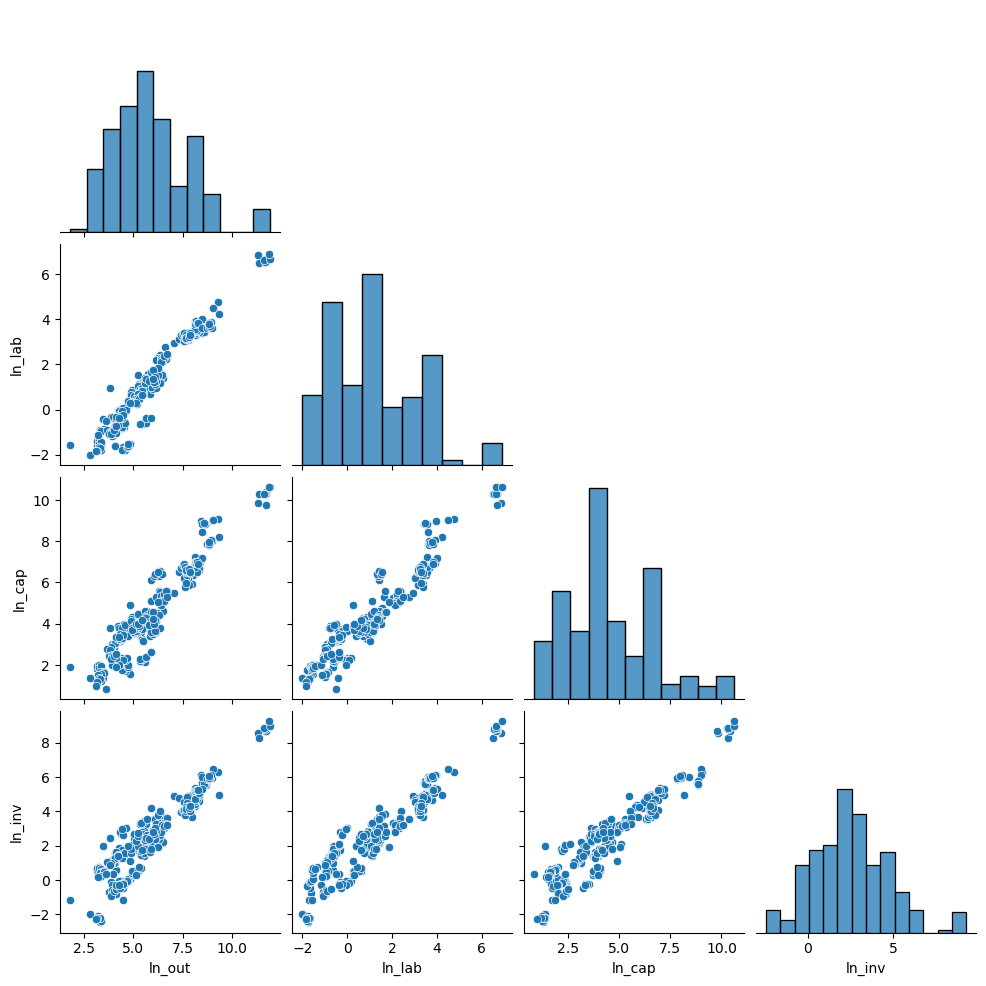

In [30]:
sns.pairplot(data=balanced_df, vars=['ln_out', 'ln_lab', 'ln_cap','ln_inv'], corner=True)

From tables and graphs above it become obvious that balanced sample is significantly less than the original one. Also all main characteristics such as mean, standard deviation are significantly less in balanced set. This results correspond to real data because a lot of companies go bankrupt. The distribution of variables seems to be close to normal. It worth to mention, that large outliers are abandoned. 

## Traditional panel estimators

In [31]:
ols = pf.feols('ln_out ~ ln_lab + ln_cap', data=df, vcov={'CRV1':'firm_id'})
ols.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  CRV1
Observations:  3956

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      3.358 |        0.091 |    37.016 |      0.000 |  3.180 |   3.536 |
| ln_lab        |      0.616 |        0.032 |    19.546 |      0.000 |  0.554 |   0.678 |
| ln_cap        |      0.355 |        0.027 |    13.199 |      0.000 |  0.302 |   0.408 |
---
RMSE: 0.538 R2: 0.914 


In [32]:
ols_balanced = pf.feols('ln_out ~ ln_lab + ln_cap', data=balanced_df, vcov={'CRV3':'firm_id'})
ols_balanced.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  CRV3
Observations:  306

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      4.028 |        0.264 |    15.284 |      0.000 |  3.492 |   4.564 |
| ln_lab        |      0.698 |        0.093 |     7.535 |      0.000 |  0.509 |   0.886 |
| ln_cap        |      0.230 |        0.072 |     3.183 |      0.003 |  0.083 |   0.377 |
---
RMSE: 0.449 R2: 0.944 


In [33]:
tfe = pf.feols('ln_out ~ ln_lab + ln_cap + C(year)', data=df, vcov={'CRV1':'firm_id'})
tfe.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  CRV1
Observations:  3956

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      3.266 |        0.090 |    36.327 |      0.000 |  3.090 |   3.443 |
| ln_lab         |      0.624 |        0.031 |    19.848 |      0.000 |  0.562 |   0.685 |
| ln_cap         |      0.347 |        0.027 |    12.894 |      0.000 |  0.295 |   0.400 |
| C(year)[T.2.0] |      0.060 |        0.017 |     3.613 |      0.000 |  0.027 |   0.092 |
| C(year)[T.3.0] |      0.100 |        0.023 |     4.295 |      0.000 |  0.054 |   0.145 |
| C(year)[T.4.0] |      0.194 |        0.027 |     7.122 |      0.000 |  0.141 |   0.248 |
| C(year)[T.5.0] |      0.160 |        0.029 |     5.557 |      0.000 |  0.103 |   0.216 |
| C(year)[T.6.0] |      0.169 |        0.028 |     5.964 |      0.000 |  0.113 |   0.

In [34]:
tfe_balanced = pf.feols('ln_out ~ ln_lab + ln_cap + C(year)', data=balanced_df, vcov={'CRV3':'firm_id'})
tfe_balanced.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  CRV3
Observations:  306

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      3.884 |        0.253 |    15.330 |      0.000 |  3.368 |   4.399 |
| ln_lab         |      0.710 |        0.096 |     7.429 |      0.000 |  0.516 |   0.905 |
| ln_cap         |      0.218 |        0.076 |     2.870 |      0.007 |  0.063 |   0.372 |
| C(year)[T.2.0] |      0.228 |        0.100 |     2.274 |      0.030 |  0.024 |   0.432 |
| C(year)[T.3.0] |      0.123 |        0.098 |     1.263 |      0.215 | -0.075 |   0.322 |
| C(year)[T.4.0] |      0.220 |        0.098 |     2.250 |      0.031 |  0.021 |   0.419 |
| C(year)[T.5.0] |      0.194 |        0.098 |     1.975 |      0.057 | -0.006 |   0.394 |
| C(year)[T.6.0] |      0.213 |        0.100 |     2.138 |      0.040 |  0.010 |   0.4

In [35]:
ffe = pf.feols('ln_out ~ ln_lab + ln_cap | firm_id', data=df, vcov={'CRV1':'firm_id'})
ffe.summary()

/Users/ivanzamatin/anaconda3/envs/stable_ds/lib/python3.11/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 8 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: firm_id
Inference:  CRV1
Observations:  3948

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ln_lab        |      0.666 |        0.072 |     9.232 |      0.000 |  0.524 |   0.807 |
| ln_cap        |      0.407 |        0.050 |     8.211 |      0.000 |  0.309 |   0.504 |
---
RMSE: 0.246 R2: 0.982 R2 Within: 0.484 


In [36]:
ffe_balanced = pf.feols('ln_out ~ ln_lab + ln_cap | firm_id', data=balanced_df, vcov={'CRV3':'firm_id'})
ffe_balanced.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: firm_id
Inference:  CRV3
Observations:  306

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ln_lab        |      0.583 |        0.111 |     5.242 |      0.000 |  0.357 |   0.809 |
| ln_cap        |      0.312 |        0.145 |     2.146 |      0.039 |  0.016 |   0.607 |
---
RMSE: 0.199 R2: 0.989 R2 Within: 0.451 


In [37]:
pf.etable(models=[ols, tfe, ffe, ols_balanced,tfe_balanced,ffe_balanced])

GT(_tbl_data=   level_0               level_1                      0  \
0     coef                ln_lab  0.616*** <br> (0.032)   
1     coef                ln_cap  0.355*** <br> (0.027)   
2     coef        C(year)[T.2.0]                          
3     coef        C(year)[T.3.0]                          
4     coef        C(year)[T.4.0]                          
5     coef        C(year)[T.5.0]                          
6     coef        C(year)[T.6.0]                          
7     coef        C(year)[T.7.0]                          
8     coef        C(year)[T.8.0]                          
9     coef        C(year)[T.9.0]                          
10    coef             Intercept  3.358*** <br> (0.091)   
11      fe               firm_id                      -   
12   stats          Observations                   3956   
13   stats             S.E. type            by: firm_id   
14   stats         R<sup>2</sup>                  0.914   
15   stats  R<sup>2</sup> Within                      -   

                        1                      2                      3  \
0   0.624*** <br> (0.031)  0.666*** <br> (0.072)  0.698*** <br> (0.093)   
1   0.347*** <br> (0.027)  0.407*** <br> (0.050)   0.230** <br> (0.072)   
2   0.060*** <br> (0.017)                                                 
3   0.100*** <br> (0.023)                                                 
4   0.194*** <br> (0.027)                                                 
5   0.160*** <br> (0.029)                                                 
6   0.169*** <br> (0.028)                                                 
7   0.153*** <br> (0.029)                                                 
8   0.169*** <br> (0.030)                                                 
9   0.175*** <br> (0.030)                                                 
10  3.266*** <br> (0.090)                         4.028*** <br> (0.264)   
11                      -                      x                      -   
12                   3956                   3948                    306   
13            by: firm_id            by: firm_id            by: firm_id   
14                  0.915                  0.982                  0.944   
15                      -                  0.484                      -   

                        4                      5  
0   0.710*** <br> (0.096)  0.583*** <br> (0.111)  
1    0.218** <br> (0.076)    0.312* <br> (0.145)  
2     0.228* <br> (0.100)                         
3      0.123 <br> (0.098)                         
4     0.220* <br> (0.098)                         
5      0.194 <br> (0.098)                         
6     0.213* <br> (0.100)                         
7     0.206* <br> (0.093)                         
8     0.250* <br> (0.094)                         
9     0.223* <br> (0.100)                         
10  3.884*** <br> (0.253)                         
11                      -                      x  
12                    306                    306  
13            by: firm_id            by: firm_id  
14                  0.945                  0.989  
15                      -                  0.451  , _body=<great_tables._gt_data.Body object at 0x30e936cd0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, co

In the table above are illustrated results of different regressions. We supposed to see strong statistical significance accrose regressions on base sample. On the other hand unbalanced set gives less significant coeficients. As we reported above, balanse set is less than original, so the results are sensentive to quantity of observations. That is why CRV3 were used in balanced dataset to escape from wrong calculations on small set. To summarize results, elasticities in labour anc capital are positive and significant, almost constant returns to scale in balaced set. Less significance in balanced data can be interpreted by selectivity bias. 

## Olley-Pakes method

In [38]:
op_df = df.copy()
op_df = op_df.replace([np.inf, -np.inf], np.nan)

op_df = op_df.dropna(subset=["firm_id", "year", "ln_out", "ln_lab", "ln_cap", "ln_inv"]).copy()
op_df["firm_id"] = op_df["firm_id"].astype(int)
op_df["year"] = op_df["year"].astype(int)
op_df = op_df.sort_values(["firm_id", "year"]).reset_index(drop=True)

if "ln_cap_l1" not in op_df.columns:
    op_df["ln_cap_l1"] = op_df.groupby("firm_id")["ln_cap"].shift(1)


In [39]:
op_step1 = pf.feols(
    "ln_out ~ ln_lab + C(year):(poly(ln_cap, 4, raw=True)*poly(ln_inv, 4, raw=True))",
    data=op_df
)
op_step1.summary()

###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  iid
Observations:  3956

| Coefficient                                                          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------------------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept                                                            |      4.025 |        0.092 |    43.881 |      0.000 |  3.845 |   4.204 |
| ln_lab                                                               |      0.591 |        0.014 |    41.039 |      0.000 |  0.563 |   0.619 |
| C(year)[1]:poly(ln_cap, 4, raw=True)[0]                              |     -1.360 |        0.279 |    -4.875 |      0.000 | -1.907 |  -0.813 |
| C(year)[2]:poly(ln_cap, 4, raw=True)[0]                              |     -0.722 |        0.408 |    -1.769 |      0.077 | -1.521 |   0.078 |
| C(year)[3]:poly(ln_cap, 4, raw=Tr

/Users/ivanzamatin/anaconda3/envs/stable_ds/lib/python3.11/site-packages/pyfixest/estimation/solvers.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=1.10437e-18): result may not be accurate.
  return solve(tZX, tZY, assume_a="pos").flatten()


In [40]:
alpha_l_op = op_step1.coef()["ln_lab"]
alpha_l_op


0.590942585607757

In [41]:
op_df["op_yhat"] = op_step1.predict()
op_df["op_fhat"] = op_df["op_yhat"] - alpha_l_op * op_df["ln_lab"]
op_df["op_lhs"] = op_df["ln_out"] - alpha_l_op * op_df["ln_lab"]
op_df["op_fhat_l1"] = op_df.groupby("firm_id")["op_fhat"].shift(1)

op_step2_df = op_df.dropna(subset=["op_lhs", "op_fhat_l1", "ln_cap", "ln_cap_l1"]).copy()
op_step2_df.shape


(3284, 19)

In [42]:
def op_step2_objective(alpha_k, degree=4, data=op_step2_df):
    alpha_k_value = float(np.atleast_1d(alpha_k)[0])
    op_y2 = data["op_lhs"] - alpha_k_value * data["ln_cap"]
    op_x2 = data["op_fhat_l1"] - alpha_k_value * data["ln_cap_l1"]
    op_reg_df = pd.DataFrame({"op_y2": op_y2, "op_x2": op_x2})
    op_step2_fit = pf.feols(f"op_y2 ~ poly(op_x2, {degree}, raw=True)", data=op_reg_df)
    residuals = np.asarray(op_step2_fit.resid())
    return float(np.sum(residuals ** 2))

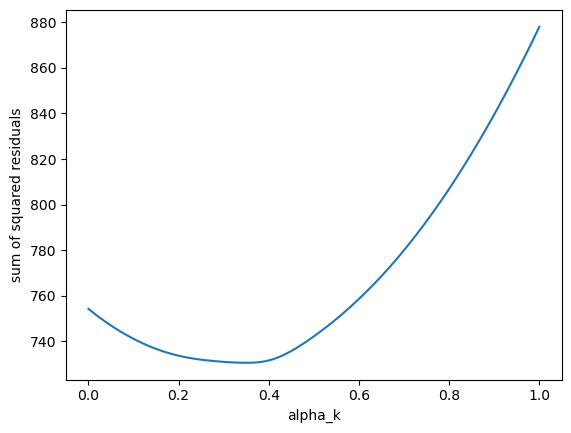

In [43]:
alpha_k_grid = np.linspace(0, 1, 101)
objective_grid = np.array([op_step2_objective(alpha_k, degree=4) for alpha_k in alpha_k_grid])

plt.figure()
plt.plot(alpha_k_grid, objective_grid)
plt.xlabel("alpha_k")
plt.ylabel("sum of squared residuals")
plt.show()


In [44]:
objective_degree4 = partial(op_step2_objective, degree=4)
op_step2_result = minimize(objective_degree4, x0=np.array([0.5]), method="Powell", tol=1e-6)

alpha_k_op = float(op_step2_result.x[0])
alpha_l_op, alpha_k_op


(0.590942585607757, 0.3510824799216892)

In [45]:
degree_list = [2, 3, 4, 5]
alpha_k_by_degree = {}

for degree in degree_list:
    objective_degree = partial(op_step2_objective, degree=degree)
    result_degree = minimize(objective_degree, x0=np.array([alpha_k_op]), method="Powell", tol=1e-6)
    alpha_k_by_degree[degree] = float(result_degree.x[0])

alpha_k_by_degree


{2: 0.3379455385290518,
 3: 0.3152481742359764,
 4: 0.3510825144158014,
 5: 0.29549250409755484}

The Olley-Pakes estimation yields output elasticities of $\alpha_L \approx 0.591$ for labor and $\alpha_K \approx 0.351$ for capital (in the baseline specification with a fourth-degree polynomial in the second stage). Both coefficients display the expected signs and exhibit plausible magnitudes for a production function: output increases with both labor and capital inputs, and the combined returns to scale with respect to (L, K) are close to constant ($\alpha_L + \alpha_K \approx 0.94$). Robustness checks with respect to the polynomial degree in the second stage indicate that α_K is moderately sensitive to the flexibility of the approximation for g(·): across polynomial orders 2 to 5, the estimates generally range between 0.30 and 0.35. Also the sum of estimates is close to zero which proved the robustness. Overall, these findings align with the theoretical intuition behind the OP approach: using investment as a proxy for unobserved productivity helps mitigate endogeneity bias compared to conventional panel data estimators.

## Olley-Pakes with endogenous exit

As in the previous section we estimate Olley-Pakes model, but we will add probit model for estimation the probobility of survivance ($\hat{p_t}$). Also the second step will be reconstructed and polinom g(·) will be estimated by ($h_{t-1}, \hat{p_t}$) with interations and year fixed effects. At the end we will provide the robustness $\alpha_K$ estimation.

In [46]:
op_exit_df = df.copy()
op_exit_df = op_exit_df.replace([np.inf, -np.inf], np.nan)

needed_columns = ["firm_id", "year", "ln_out", "ln_lab", "ln_cap", "ln_inv", "exit"]
op_exit_df = op_exit_df.dropna(subset=needed_columns).copy()

op_exit_df["firm_id"] = op_exit_df["firm_id"].astype(int)
op_exit_df["year"] = op_exit_df["year"].astype(int)
op_exit_df = op_exit_df.sort_values(["firm_id", "year"]).reset_index(drop=True)

op_exit_df["survive"] = 1 - op_exit_df["exit"]

if "ln_cap_l1" not in op_exit_df.columns:
    op_exit_df["ln_cap_l1"] = op_exit_df.groupby("firm_id")["ln_cap"].shift(1)


In [47]:
survive_probit = pf.feglm("survive ~ ln_cap + ln_inv", data=op_exit_df, family="probit")
survive_probit.tidy()


,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,0.946661,0.068038,13.913716,0.000000,0.813309,1.080013
ln_cap,0.007896,0.030176,0.261678,0.793570,-0.051248,0.067040
ln_inv,-0.010488,0.030501,-0.343861,0.730951,-0.070268,0.049292


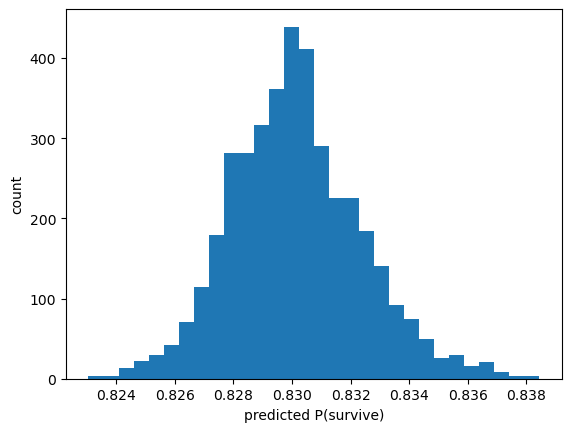

In [48]:
op_exit_df["survive_prob"] = survive_probit.predict(type="response")

plt.figure()
plt.hist(op_exit_df["survive_prob"].dropna(), bins=30)
plt.xlabel("predicted P(survive)")
plt.ylabel("count")
plt.show()


In [49]:
op_exit_step1 = pf.feols(
    "ln_out ~ ln_lab + C(year):(poly(ln_cap, 4, raw=True)*poly(ln_inv, 4, raw=True))",
    data=op_exit_df
)
op_exit_step1.summary()


###

Estimation:  OLS
Dep. var.: ln_out, Fixed effects: 0
Inference:  iid
Observations:  3956

| Coefficient                                                          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------------------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept                                                            |      4.025 |        0.092 |    43.881 |      0.000 |  3.845 |   4.204 |
| ln_lab                                                               |      0.591 |        0.014 |    41.039 |      0.000 |  0.563 |   0.619 |
| C(year)[1]:poly(ln_cap, 4, raw=True)[0]                              |     -1.360 |        0.279 |    -4.875 |      0.000 | -1.907 |  -0.813 |
| C(year)[2]:poly(ln_cap, 4, raw=True)[0]                              |     -0.722 |        0.408 |    -1.769 |      0.077 | -1.521 |   0.078 |
| C(year)[3]:poly(ln_cap, 4, raw=Tr

/Users/ivanzamatin/anaconda3/envs/stable_ds/lib/python3.11/site-packages/pyfixest/estimation/solvers.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=1.10437e-18): result may not be accurate.
  return solve(tZX, tZY, assume_a="pos").flatten()


In [50]:
alpha_l_op_exit = op_exit_step1.coef()["ln_lab"]

op_exit_df["op_yhat"] = op_exit_step1.predict()
op_exit_df["op_fhat"] = op_exit_df["op_yhat"] - alpha_l_op_exit * op_exit_df["ln_lab"]
op_exit_df["op_lhs"] = op_exit_df["ln_out"] - alpha_l_op_exit * op_exit_df["ln_lab"]
op_exit_df["op_fhat_l1"] = op_exit_df.groupby("firm_id")["op_fhat"].shift(1)

op_exit_step2_df = op_exit_df.dropna(subset=["op_lhs", "op_fhat_l1", "ln_cap", "ln_cap_l1", "survive_prob", "year"]).copy()
op_exit_step2_df.shape


(3284, 21)

In [51]:
def op_exit_step2_objective(alpha_k, degree=3, data=op_exit_step2_df):
    alpha_k_value = float(np.atleast_1d(alpha_k)[0])
    y2 = data["op_lhs"] - alpha_k_value * data["ln_cap"]
    h = data["op_fhat_l1"] - alpha_k_value * data["ln_cap_l1"]
    reg_df = pd.DataFrame(
        {
            "y2": y2.to_numpy(),
            "h": h.to_numpy(),
            "survive_prob": data["survive_prob"].to_numpy(),
            "year": data["year"].to_numpy(),
        }
    )
    try:
        op2_fit = pf.feols(
            f"y2 ~ poly(h, {degree}, raw=True)*poly(survive_prob, {degree}, raw=True) | year",
            data=reg_df,
            solver="scipy.sparse.linalg.lsqr",
            drop_intercept=True,
            collin_tol=1e-10,
        )
        residuals = np.asarray(op2_fit.resid())
        return float(np.sum(residuals ** 2))
    except Exception:
        return 1e30


In [52]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    objective_degree3 = partial(op_exit_step2_objective, degree=3)
    op_exit_step2_result = minimize(
        objective_degree3,
        x0=np.array([0.5]),
        method="Powell",
        bounds=[(0.0, 1.5)],
        tol=1e-6,
    )

alpha_k_op_exit = float(op_exit_step2_result.x[0])
alpha_l_op_exit, alpha_k_op_exit


(0.590942585607757, 0.3118235381512582)

In [53]:
degree_list = [2, 3, 4, 5]
alpha_k_exit_by_degree = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for degree in degree_list:
        objective_degree = partial(op_exit_step2_objective, degree=degree)
        result_degree = minimize(
            objective_degree,
            x0=np.array([alpha_k_op_exit]),
            method="Powell",
            bounds=[(0.0, 1.5)],
            tol=1e-6,
        )
        alpha_k_exit_by_degree[degree] = float(result_degree.x[0])

alpha_k_exit_by_degree


{2: 0.311828918611036,
 3: 0.31195078442069674,
 4: 0.3148637671583585,
 5: 0.31810129008021254}

The survival equation estimated via probit model does not show a strong statistical relationship: the coefficients for both capital and investment are small and statistically insignificant. This implies that the predicted survival probability $\hat{p_t}$ varies only modestly across firms and over time. Nevertheless, in the modified Olley-Pakes specification—where the second-stage function g(·) depends on both the productivity proxy $h_{t−1}$ and the predicted survival probability $\hat{p_t}$—we obtain estimated elasticities of $\alpha_L \approx 0.591$ for labor and $\alpha_K \approx 0.312$ for capital. Compared to the “standard” OP specification (point 4 above), the estimated elasticity of capital decreases (from approximately 0.35 to 0.31). This is consistent with the theoretical expectation of selection bias: firms with lower productivity are more likely to exit the market, and failing to account for this survival mechanism could lead to an overestimation of capital’s contribution to output. The robustness of the results with respect to the polynomial degree in the second stage is notably strong in this specification: $\alpha_K$ remains stable (around 0.312 across polynomial degrees 2–5). This stability reinforces confidence in the reliability of the obtained estimate and suggests that the correction for selection bias is robust to different functional form assumptions for the unobserved productivity process.

## Bootstrap (20 points)

The objective is to obtain standard errors and confidence intervals for the production function parameters ($\alpha_L$, $\alpha_K$) estimated using the two-step Olley–Pakes procedure. To do this, we apply a firm-level clustered bootstrap in which firms are resampled with replacement based on their firm identifiers. When the same firm appears multiple times in a bootstrap sample, each duplicate is treated as a distinct firm by assigning it a new firm identifier. For every bootstrap replication, the full Olley–Pakes estimation is carried out from scratch, including both the first-step and second-step regressions, and the resulting estimates of ($\alpha_L$, $\alpha_K$) are stored. Inference is then based on the empirical distribution of these bootstrap estimates, from which standard errors, t-statistics, and p-values are computed using a normal approximation, along with percentile-based confidence intervals. This entire procedure is repeated across different polynomial specifications and in models allowing for endogenous output in order to assess the robustness of the results.

In [54]:
def olley_pakes_estimate(
    data,
    step1_degree=4,
    step2_degree=4,
    endogenous_exit=False,
    alpha_k_start=0.5,
    alpha_k_bounds=(0.0, 1.5),
    step2_solver="scipy.sparse.linalg.lsqr",
    step2_drop_intercept=True,
    step2_collin_tol=1e-10,
):
    op_data = data.copy()
    op_data = op_data.replace([np.inf, -np.inf], np.nan)

    required_step1 = ["firm_id", "year", "ln_out", "ln_lab", "ln_cap", "ln_inv"]
    if endogenous_exit:
        required_step1 = required_step1 + ["exit"]

    op_data = op_data.dropna(subset=required_step1).copy()
    op_data["firm_id"] = op_data["firm_id"].astype(int)
    op_data["year"] = op_data["year"].astype(int)
    op_data = op_data.sort_values(["firm_id", "year"]).reset_index(drop=True)

    if "ln_cap_l1" not in op_data.columns:
        op_data["ln_cap_l1"] = op_data.groupby("firm_id")["ln_cap"].shift(1)

    survive_probit = None
    if endogenous_exit:
        op_data["survive"] = 1 - op_data["exit"]
        survive_probit = pf.feglm("survive ~ ln_cap + ln_inv", data=op_data, family="probit")
        op_data["survive_prob"] = survive_probit.predict(type="response")

    step1_formula = f"ln_out ~ ln_lab + C(year):(poly(ln_cap, {step1_degree}, raw=True)*poly(ln_inv, {step1_degree}, raw=True))"
    step1_fit = pf.feols(step1_formula, data=op_data)
    alpha_l = float(step1_fit.coef()["ln_lab"])

    op_data["op_yhat"] = step1_fit.predict()
    op_data["op_fhat"] = op_data["op_yhat"] - alpha_l * op_data["ln_lab"]
    op_data["op_lhs"] = op_data["ln_out"] - alpha_l * op_data["ln_lab"]
    op_data["op_fhat_l1"] = op_data.groupby("firm_id")["op_fhat"].shift(1)

    step2_needed = ["op_lhs", "op_fhat_l1", "ln_cap", "ln_cap_l1"]
    if endogenous_exit:
        step2_needed = step2_needed + ["survive_prob", "year"]

    step2_df = op_data.dropna(subset=step2_needed).copy()

    if len(step2_df) < 20:
        raise ValueError("Too few observations for OP step 2 after dropping missing values.")

    def step2_objective(alpha_k, degree=step2_degree, data_step2=step2_df):
        alpha_k_value = float(np.atleast_1d(alpha_k)[0])

        y2 = data_step2["op_lhs"] - alpha_k_value * data_step2["ln_cap"]
        h = data_step2["op_fhat_l1"] - alpha_k_value * data_step2["ln_cap_l1"]

        if endogenous_exit:
            reg_df = pd.DataFrame(
                {
                    "y2": y2.to_numpy(),
                    "h": h.to_numpy(),
                    "survive_prob": data_step2["survive_prob"].to_numpy(),
                    "year": data_step2["year"].to_numpy(),
                }
            )
            step2_formula = f"y2 ~ poly(h, {degree}, raw=True)*poly(survive_prob, {degree}, raw=True) | year"
        else:
            reg_df = pd.DataFrame({"y2": y2.to_numpy(), "h": h.to_numpy()})
            step2_formula = f"y2 ~ poly(h, {degree}, raw=True)"

        try:
            step2_fit = pf.feols(
                step2_formula,
                data=reg_df,
                solver=step2_solver,
                drop_intercept=step2_drop_intercept,
                collin_tol=step2_collin_tol,
            )
            residuals = np.asarray(step2_fit.resid())
            return float(np.sum(residuals ** 2))
        except Exception:
            return 1e30

    objective_fn = partial(step2_objective, degree=step2_degree)

    step2_result = minimize(
        objective_fn,
        x0=np.array([alpha_k_start]),
        method="Powell",
        bounds=[alpha_k_bounds],
        tol=1e-6,
    )

    alpha_k = float(step2_result.x[0])

    result = {
        "alpha_l": alpha_l,
        "alpha_k": alpha_k,
        "step1_fit": step1_fit,
        "step2_result": step2_result,
        "n_step1": int(step1_fit._N),
        "n_step2": int(len(step2_df)),
        "endogenous_exit": bool(endogenous_exit),
        "step1_degree": int(step1_degree),
        "step2_degree": int(step2_degree),
    }

    if endogenous_exit:
        result["survive_probit"] = survive_probit

    return result


In [55]:
def cluster_bootstrap_by_firm(data, firm_id_col="firm_id", random_state=None):
    rng = np.random.RandomState(random_state)

    original_firms = data[firm_id_col].dropna().astype(int).unique()
    sampled_firms = rng.choice(original_firms, size=len(original_firms), replace=True)

    bootstrap_parts = []
    new_firm_id = 1

    for firm_id in sampled_firms:
        firm_block = data.loc[data[firm_id_col].astype(int) == int(firm_id)].copy()
        firm_block[firm_id_col] = new_firm_id
        bootstrap_parts.append(firm_block)
        new_firm_id += 1

    bootstrap_sample = pd.concat(bootstrap_parts, axis=0, ignore_index=True)
    return bootstrap_sample


In [56]:
def bootstrap_olley_pakes_summary(
    data,
    n_samples=100,
    random_state=None,
    step1_degree=4,
    step2_degree=4,
    endogenous_exit=False,
    alpha_k_start=0.5,
    alpha_k_bounds=(0.0, 1.5),
    max_attempts_multiplier=5,
    tqdm_desc=None,
):
    point_est = olley_pakes_estimate(
        data=data,
        step1_degree=step1_degree,
        step2_degree=step2_degree,
        endogenous_exit=endogenous_exit,
        alpha_k_start=alpha_k_start,
        alpha_k_bounds=alpha_k_bounds,
    )

    point_alpha_l = float(point_est["alpha_l"])
    point_alpha_k = float(point_est["alpha_k"])

    rng = np.random.RandomState(random_state)

    bootstrap_estimates = []
    attempts = 0
    max_attempts = int(n_samples * max_attempts_multiplier)

    if tqdm_desc is None:
        tqdm_desc = f"Bootstrap OP{' + exit' if endogenous_exit else ''} (d2={step2_degree})"

    progress_bar = tqdm(total=n_samples, desc=tqdm_desc)

    try:
        while len(bootstrap_estimates) < n_samples and attempts < max_attempts:
            attempts += 1
            sample_seed = int(rng.randint(0, 2**31 - 1))
            bootstrap_sample = cluster_bootstrap_by_firm(data, firm_id_col="firm_id", random_state=sample_seed)

            try:
                boot_est = olley_pakes_estimate(
                    data=bootstrap_sample,
                    step1_degree=step1_degree,
                    step2_degree=step2_degree,
                    endogenous_exit=endogenous_exit,
                    alpha_k_start=alpha_k_start,
                    alpha_k_bounds=alpha_k_bounds,
                )
                boot_alpha_l = float(boot_est["alpha_l"])
                boot_alpha_k = float(boot_est["alpha_k"])

                if np.isfinite(boot_alpha_l) and np.isfinite(boot_alpha_k):
                    bootstrap_estimates.append([boot_alpha_l, boot_alpha_k])
                    progress_bar.update(1)
            except Exception:
                pass
    finally:
        progress_bar.close()

    bootstrap_estimates = np.asarray(bootstrap_estimates)

    if len(bootstrap_estimates) == 0:
        raise ValueError("No successful bootstrap replications. Try fewer degrees, different start/bounds, or higher max_attempts_multiplier.")

    se_alpha_l = float(np.std(bootstrap_estimates[:, 0], ddof=1))
    se_alpha_k = float(np.std(bootstrap_estimates[:, 1], ddof=1))

    t_alpha_l = point_alpha_l / se_alpha_l
    t_alpha_k = point_alpha_k / se_alpha_k

    p_alpha_l = float(stats.norm.sf(abs(t_alpha_l)) * 2)
    p_alpha_k = float(stats.norm.sf(abs(t_alpha_k)) * 2)

    ci_alpha_l = np.quantile(bootstrap_estimates[:, 0], [0.025, 0.975])
    ci_alpha_k = np.quantile(bootstrap_estimates[:, 1], [0.025, 0.975])

    summary = pd.DataFrame(
        {
            "parameter": ["alpha_l", "alpha_k"],
            "point_estimate": [point_alpha_l, point_alpha_k],
            "bootstrap_se": [se_alpha_l, se_alpha_k],
            "t_stat": [t_alpha_l, t_alpha_k],
            "p_value": [p_alpha_l, p_alpha_k],
            "ci_lower": [float(ci_alpha_l[0]), float(ci_alpha_k[0])],
            "ci_upper": [float(ci_alpha_l[1]), float(ci_alpha_k[1])],
            "n_bootstrap_success": [int(len(bootstrap_estimates)), int(len(bootstrap_estimates))],
            "n_attempts": [int(attempts), int(attempts)],
            "endogenous_exit": [bool(endogenous_exit), bool(endogenous_exit)],
            "step1_degree": [int(step1_degree), int(step1_degree)],
            "step2_degree": [int(step2_degree), int(step2_degree)],
        }
    )

    return summary, bootstrap_estimates, point_est


In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bootstrap_summary_op_exit, bootstrap_draws_op_exit, point_est_op_exit = bootstrap_olley_pakes_summary(
    data=df,
    n_samples=10,
    random_state=42,
    step1_degree=4,
    step2_degree=3,
    endogenous_exit=True,
    )
    
bootstrap_summary_op_exit

Bootstrap OP + exit (d2=3):   0%|          | 0/10 [00:00<?, ?it/s]

,parameter,point_estimate,bootstrap_se,t_stat,p_value,ci_lower,ci_upper,n_bootstrap_success,n_attempts,endogenous_exit,step1_degree,step2_degree
0,alpha_l,0.590943,0.024044,24.577196,2.215035e-133,0.553175,0.631716,10,10,True,4,3
1,alpha_k,0.311824,0.067888,4.593194,4.365124e-06,0.242234,0.461357,10,10,True,4,3


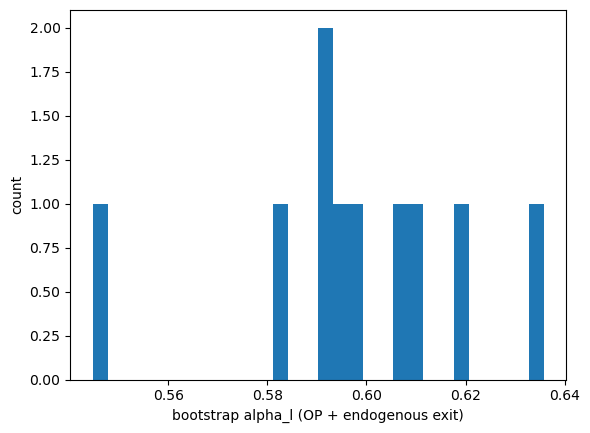

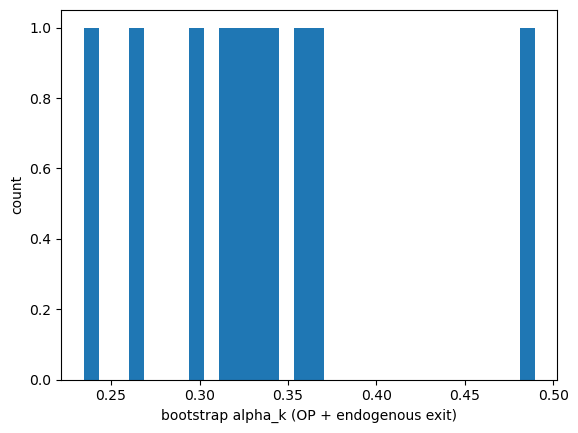

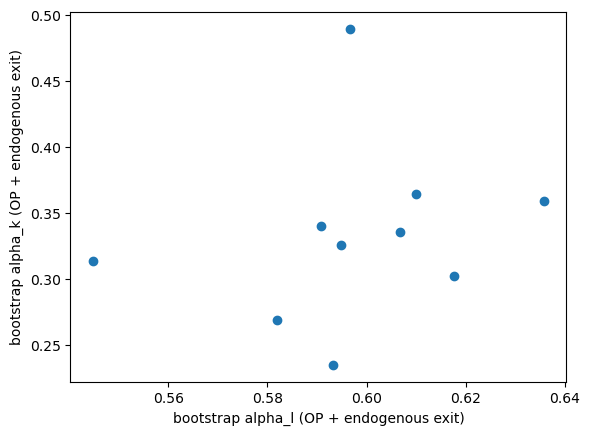

In [58]:
plt.figure()
plt.hist(bootstrap_draws_op_exit[:, 0], bins=30)
plt.xlabel("bootstrap alpha_l (OP + endogenous exit)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(bootstrap_draws_op_exit[:, 1], bins=30)
plt.xlabel("bootstrap alpha_k (OP + endogenous exit)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.scatter(bootstrap_draws_op_exit[:, 0], bootstrap_draws_op_exit[:, 1])
plt.xlabel("bootstrap alpha_l (OP + endogenous exit)")
plt.ylabel("bootstrap alpha_k (OP + endogenous exit)")
plt.show()

In [59]:
degree_list = [2, 3, 4, 5]
bootstrap_by_degree = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for degree in tqdm(degree_list, desc="Degrees loop"):
        summary_degree, draws_degree, point_degree = bootstrap_olley_pakes_summary(
            data=df,
            n_samples=5,
            random_state=123 + degree,
            step1_degree=4,
            step2_degree=degree,
            endogenous_exit=True,
            tqdm_desc=f"Bootstrap OP + exit (d2={degree})",
        )
        bootstrap_by_degree[degree] = summary_degree

bootstrap_by_degree


Degrees loop:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrap OP + exit (d2=2):   0%|          | 0/5 [00:00<?, ?it/s]

Bootstrap OP + exit (d2=3):   0%|          | 0/5 [00:00<?, ?it/s]

Bootstrap OP + exit (d2=4):   0%|          | 0/5 [00:00<?, ?it/s]

Bootstrap OP + exit (d2=5):   0%|          | 0/5 [00:00<?, ?it/s]

{2:   parameter  point_estimate  bootstrap_se     t_stat       p_value  ci_lower  \
 0   alpha_l        0.590943      0.028103  21.027632  3.664961e-98  0.555143   
 1   alpha_k        0.311829      0.111280   2.802200  5.075541e-03  0.163828   
 
    ci_upper  n_bootstrap_success  n_attempts  endogenous_exit  step1_degree  \
 0  0.620303                    5           5             True             4   
 1  0.393878                    5           5             True             4   
 
    step2_degree  
 0             2  
 1             2  ,
 3:   parameter  point_estimate  bootstrap_se     t_stat        p_value  ci_lower  \
 0   alpha_l        0.590943      0.017019  34.721650  3.713604e-264  0.581370   
 1   alpha_k        0.311824      0.065456   4.763858   1.899258e-06  0.264704   
 
    ci_upper  n_bootstrap_success  n_attempts  endogenous_exit  step1_degree  \
 0  0.621284                    5           5             True             4   
 1  0.391060                    5        

A firm-level clustered bootstrap is used in which, at each replication, firm identifiers are resampled with replacement. Entire blocks of observations corresponding to the selected firms are duplicated and reassigned new firm identifiers, after which the full two-step Olley–Pakes procedure is re-estimated from scratch, including both the first and second steps. For the baseline OP specification with endogenous exit and a third-degree polynomial in the second step, the point estimates remain close to the original results, with $\alpha_L \approx 0.591$ and $\alpha_K \approx 0.312$. When assessing robustness with respect to the polynomial degree in the second step, varying it from two to five, the point estimates of \alpha_K remain stable in a narrow range around 0.30–0.314, while the bootstrap distributions yield reasonable confidence intervals, roughly spanning from about 0.16–0.23 on the lower end to 0.36–0.41 on the upper end depending on the degree. It is important to note, however, that in the current run the number of bootstrap replications is small, on the order of five to ten, so the resulting standard errors and confidence intervals should be viewed as illustrative rather than definitive; substantially more replications are typically required to obtain reportable inference.

## Productivity analysis

Firm productivity is measured as total factor productivity, denoted $\hat{\omega}_{it}$, and. Specifically, using the coefficients obtained from the Olley–Pakes estimation with endogenous exit, productivity is defined as the difference between log output and the predicted contribution of observed inputs, $\hat{\omega}_{it} = \ln(\text{output}_{it}) - \alpha_L \ln(\text{labor}_{it}) - \alpha_K \ln(\text{capital}_{it})$. 
We begin with a descriptive examination of the distribution of estimated productivity across firms and over time. To explore the role of selection, the distribution of $\hat{\omega}_{it}$ is compared between firms that exit the market and those that continue to operate. Exiting firms are expected to have systematically lower productivity, reflecting the endogenous exit mechanism emphasized in dynamic models of firm behavior, where firms with sufficiently low productivity draw choose to leave the market.

This relationship is further analyzed by computing exit rates across quantiles of the productivity distribution. Firms are grouped according to their position in the distribution of $\hat{\omega}_{it}$, and the probability of exit is calculated within each group. To formally quantify relationship, a probit model of exit is estimated in which the probability of firm exit is regressed on estimated productivity, potentially augmented with additional firm-level controls and year fixed effects to capture aggregate shocks.

In [60]:
alpha_l_final = float(point_est_op_exit["alpha_l"])
alpha_k_final = float(point_est_op_exit["alpha_k"])

In [61]:
productivity_df = df.copy()
productivity_df = productivity_df.replace([np.inf, -np.inf], np.nan)
productivity_df = productivity_df.dropna(subset=["firm_id", "year", "ln_out", "ln_lab", "ln_cap", "exit"]).copy()

productivity_df["firm_id"] = productivity_df["firm_id"].astype(int)
productivity_df["year"] = productivity_df["year"].astype(int)
productivity_df = productivity_df.sort_values(["firm_id", "year"]).reset_index(drop=True)

productivity_df["omega_hat"] = productivity_df["ln_out"] - alpha_l_final * productivity_df["ln_lab"] - alpha_k_final * productivity_df["ln_cap"]
productivity_df["omega_hat_l1"] = productivity_df.groupby("firm_id")["omega_hat"].shift(1)

productivity_df[["omega_hat", "omega_hat_l1"]].describe()


,omega_hat,omega_hat_l1
count,3956.000000,3284.000000
mean,3.556642,3.548162
std,0.553077,0.559837
min,0.084142,0.084142
25%,3.276073,3.270208
50%,3.576098,3.569832
75%,3.861051,3.856016
max,5.296787,5.283552


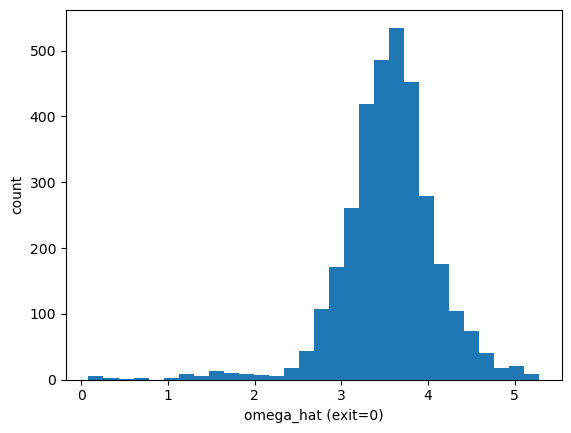

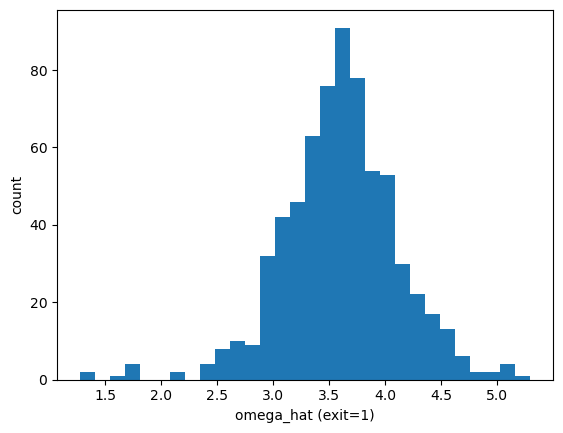

(3.548161684511862, 3.598085089256607)

In [62]:
omega_exit0 = productivity_df.loc[productivity_df["exit"] == 0, "omega_hat"].dropna()
omega_exit1 = productivity_df.loc[productivity_df["exit"] == 1, "omega_hat"].dropna()

plt.figure()
plt.hist(omega_exit0, bins=30)
plt.xlabel("omega_hat (exit=0)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(omega_exit1, bins=30)
plt.xlabel("omega_hat (exit=1)")
plt.ylabel("count")
plt.show()

omega_exit0.mean(), omega_exit1.mean()


In [63]:
quantile_df = productivity_df.dropna(subset=["omega_hat"]).copy()
quantile_df["omega_quantile"] = pd.qcut(quantile_df["omega_hat"], q=5, labels=False) + 1

exit_rate_by_quantile = (
    quantile_df.groupby("omega_quantile")
    .agg(
        mean_omega=("omega_hat", "mean"),
        exit_rate=("exit", "mean"),
        n_obs=("exit", "size"),
    )
    .reset_index()
)

exit_rate_by_quantile


,omega_quantile,mean_omega,exit_rate,n_obs
0,1,2.806266,0.161616,792
1,2,3.340877,0.159292,791
2,3,3.574842,0.169406,791
3,4,3.799730,0.166877,791
4,5,4.262444,0.192162,791


In [64]:
probit_df = productivity_df.dropna(subset=["omega_hat_l1", "ln_cap", "ln_inv", "exit"]).copy()
probit_df["exit"] = probit_df["exit"].astype(int)

exit_probit = pf.feglm(
    "exit ~ omega_hat_l1 + ln_cap + ln_inv",
    data=probit_df,
    family="probit",
)

exit_probit.tidy()


,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,-1.057423,0.180059,-5.872645,4.288962e-09,-1.410333,-0.704514
omega_hat_l1,0.088465,0.046960,1.883814,5.959021e-02,-0.003576,0.180505
ln_cap,-0.035166,0.031883,-1.102960,2.700447e-01,-0.097657,0.027324
ln_inv,0.023067,0.032576,0.708097,4.788849e-01,-0.040781,0.086914


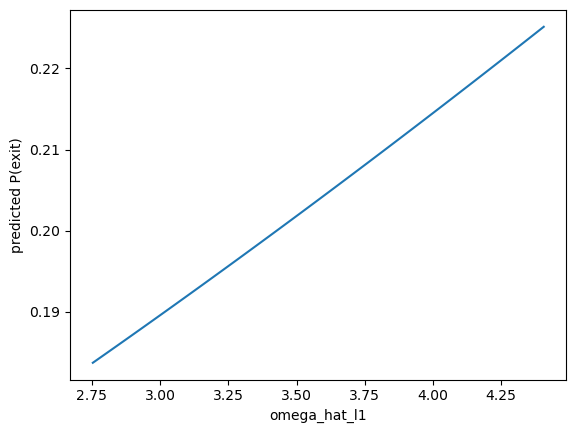

In [65]:
grid_df = probit_df.copy()

reference_year = int(grid_df["year"].mode().iloc[0])
median_ln_cap = float(grid_df["ln_cap"].median())
median_ln_inv = float(grid_df["ln_inv"].median())

omega_grid = np.linspace(float(grid_df["omega_hat_l1"].quantile(0.05)), float(grid_df["omega_hat_l1"].quantile(0.95)), 60)

predict_df = pd.DataFrame(
    {
        "omega_hat_l1": omega_grid,
        "ln_cap": median_ln_cap,
        "ln_inv": median_ln_inv,
        "year": reference_year,
    }
)

predicted_exit_prob = exit_probit.predict(newdata=predict_df, type="response")

plt.figure()
plt.plot(omega_grid, predicted_exit_prob)
plt.xlabel("omega_hat_l1")
plt.ylabel("predicted P(exit)")
plt.show()


The resulting productivity measure behaves well empirically: the distribution of $\hat{\omega}_{it}$ contains finite values, and the lagged productivity measure $\hat{\omega}_{i,t-1}$ is available for the vast majority of observations, making it suitable for subsequent dynamic and exit analyses. However, descriptive comparisons across exit status yield results that differ from the standard predictions of models with productivity-driven selection. Firms that exit the market do not appear to be less productive on average; if anything, their mean productivity is slightly higher than that of continuing firms. Consistently, exit rates computed across quantiles of the productivity distribution do not display a declining pattern as productivity increases, but instead remain relatively flat. This lack of a monotonic relationship contrasts with the canonical implication of the Olley–Pakes framework, in which lower productivity firms are more likely to exit. The regression analysis reinforces this picture. A probit model of firm exit that includes lagged productivity and additional controls, along with year fixed effects, yields a positive coefficient on lagged productivity, albeit only marginally statistically significant. Thus, within this dataset, there is no compelling evidence that lower productivity is associated with a higher probability of exit; if anything, the estimated relationship points in the opposite direction. The Interpretation is that the estimated productivity measure captures more than pure technological efficiency and may embed demand-side or price-related components, especially if output is measured in revenue terms. Finally, the construction of the exit variable or the pattern of firm observability over time may induce a non-standard selection mechanism, obscuring the expected negative relationship between productivity and exit.